# 选取自编码器结构


## 1. 对比各种结构的自编码器效果


本例中，Autoencoder的encoder是2层的MLP。第1层的单元数取3～8，第2层的单元数比第一层单元数少，且不大于5。decoder与encoder对称。尝试几种网络结构，以训练若干次后的测试误差为指标，评价各种结构的优劣。


划分训练集和测试集


In [2]:
from Network import *
import pandas as pd
import torch

# 选取需要的列
COLUMN_INDEX = [
    "Temp (°C)",
    "Dew Point Temp (°C)",
    "Rel Hum (%)",
    "Wind Spd (km/h)",
    "Stn Press (kPa)",
]
data = pd.read_csv("Data/DataSet.csv")[COLUMN_INDEX].to_numpy()
data_tensor = torch.tensor(data, dtype=torch.float32)


# 设置随机种子以确保结果可重复
torch.manual_seed(42)
train_loader, test_loader = Split2Loaders(
    data_tensor, data_tensor, BATCHSIZE=32, RATIO=0.7, SHUFFLE=True
)

各训练80个epoch，对比训练结果


In [2]:
import itertools
COLUMN_INDEX_COMPARISON = ["LAYER_1", "LAYER_2", "LOSS_TRAIN", "LOSS_TEST"]
df = pd.DataFrame(data=None, columns=COLUMN_INDEX_COMPARISON)

for Layer_1_num, Layer_2_num in itertools.product(range(2, 17), range(2, 17)):
    model = MyAutoencoder(
        input_size=5,
        hidden_size_1=Layer_1_num,
        hidden_size_2=Layer_2_num,
        dropout_prob=0,
    )
    INIT_WEIGHTS_ZERO(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
    LOSS_HISTORY_TRAIN, LOSS_HISTORY_TEST = TRAIN_NO_PROGRESS_BAR(
        model,
        NUM_EPOCHS=80,
        OPTIMIZER=optimizer,
        TRAIN_LOADER=train_loader,
        TEST_LOADER=test_loader,
        LOSS_TYPE=nn.MSELoss(),
        DEVICE=0,
    )
    RESULT = [
        Layer_1_num,
        Layer_2_num,
        LOSS_HISTORY_TRAIN[-1].cpu().numpy(),
        LOSS_HISTORY_TEST[-1].cpu().numpy(),
    ]
    df = df.append(
        pd.Series(data=RESULT, index=COLUMN_INDEX_COMPARISON), ignore_index=True
    )

根据测试误差排序，并保存


In [3]:
# 按照测试集上的误差，从小到达排列
df = df.sort_values(by="LOSS_TEST", axis=0, ascending=True)
df.to_csv("Networks/AE_Comparison.csv", index=False)
df

,LAYER_1,LAYER_2,LOSS_TRAIN,LOSS_TEST
155,12,7,108.532524,105.64162
173,13,10,108.52798,105.686
113,9,10,108.49024,105.71137
104,8,16,108.44689,105.716606
54,5,11,108.600044,105.71824
...,...,...,...,...
131,10,13,108.45762,106.21842
134,10,16,108.51615,106.26225
183,14,5,108.54049,106.33059
77,7,4,108.425385,106.50571


可视化


c:\Users\CTC\Desktop\temporary working library\Python\Optimization_Group_Work\Visualization.py:236: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


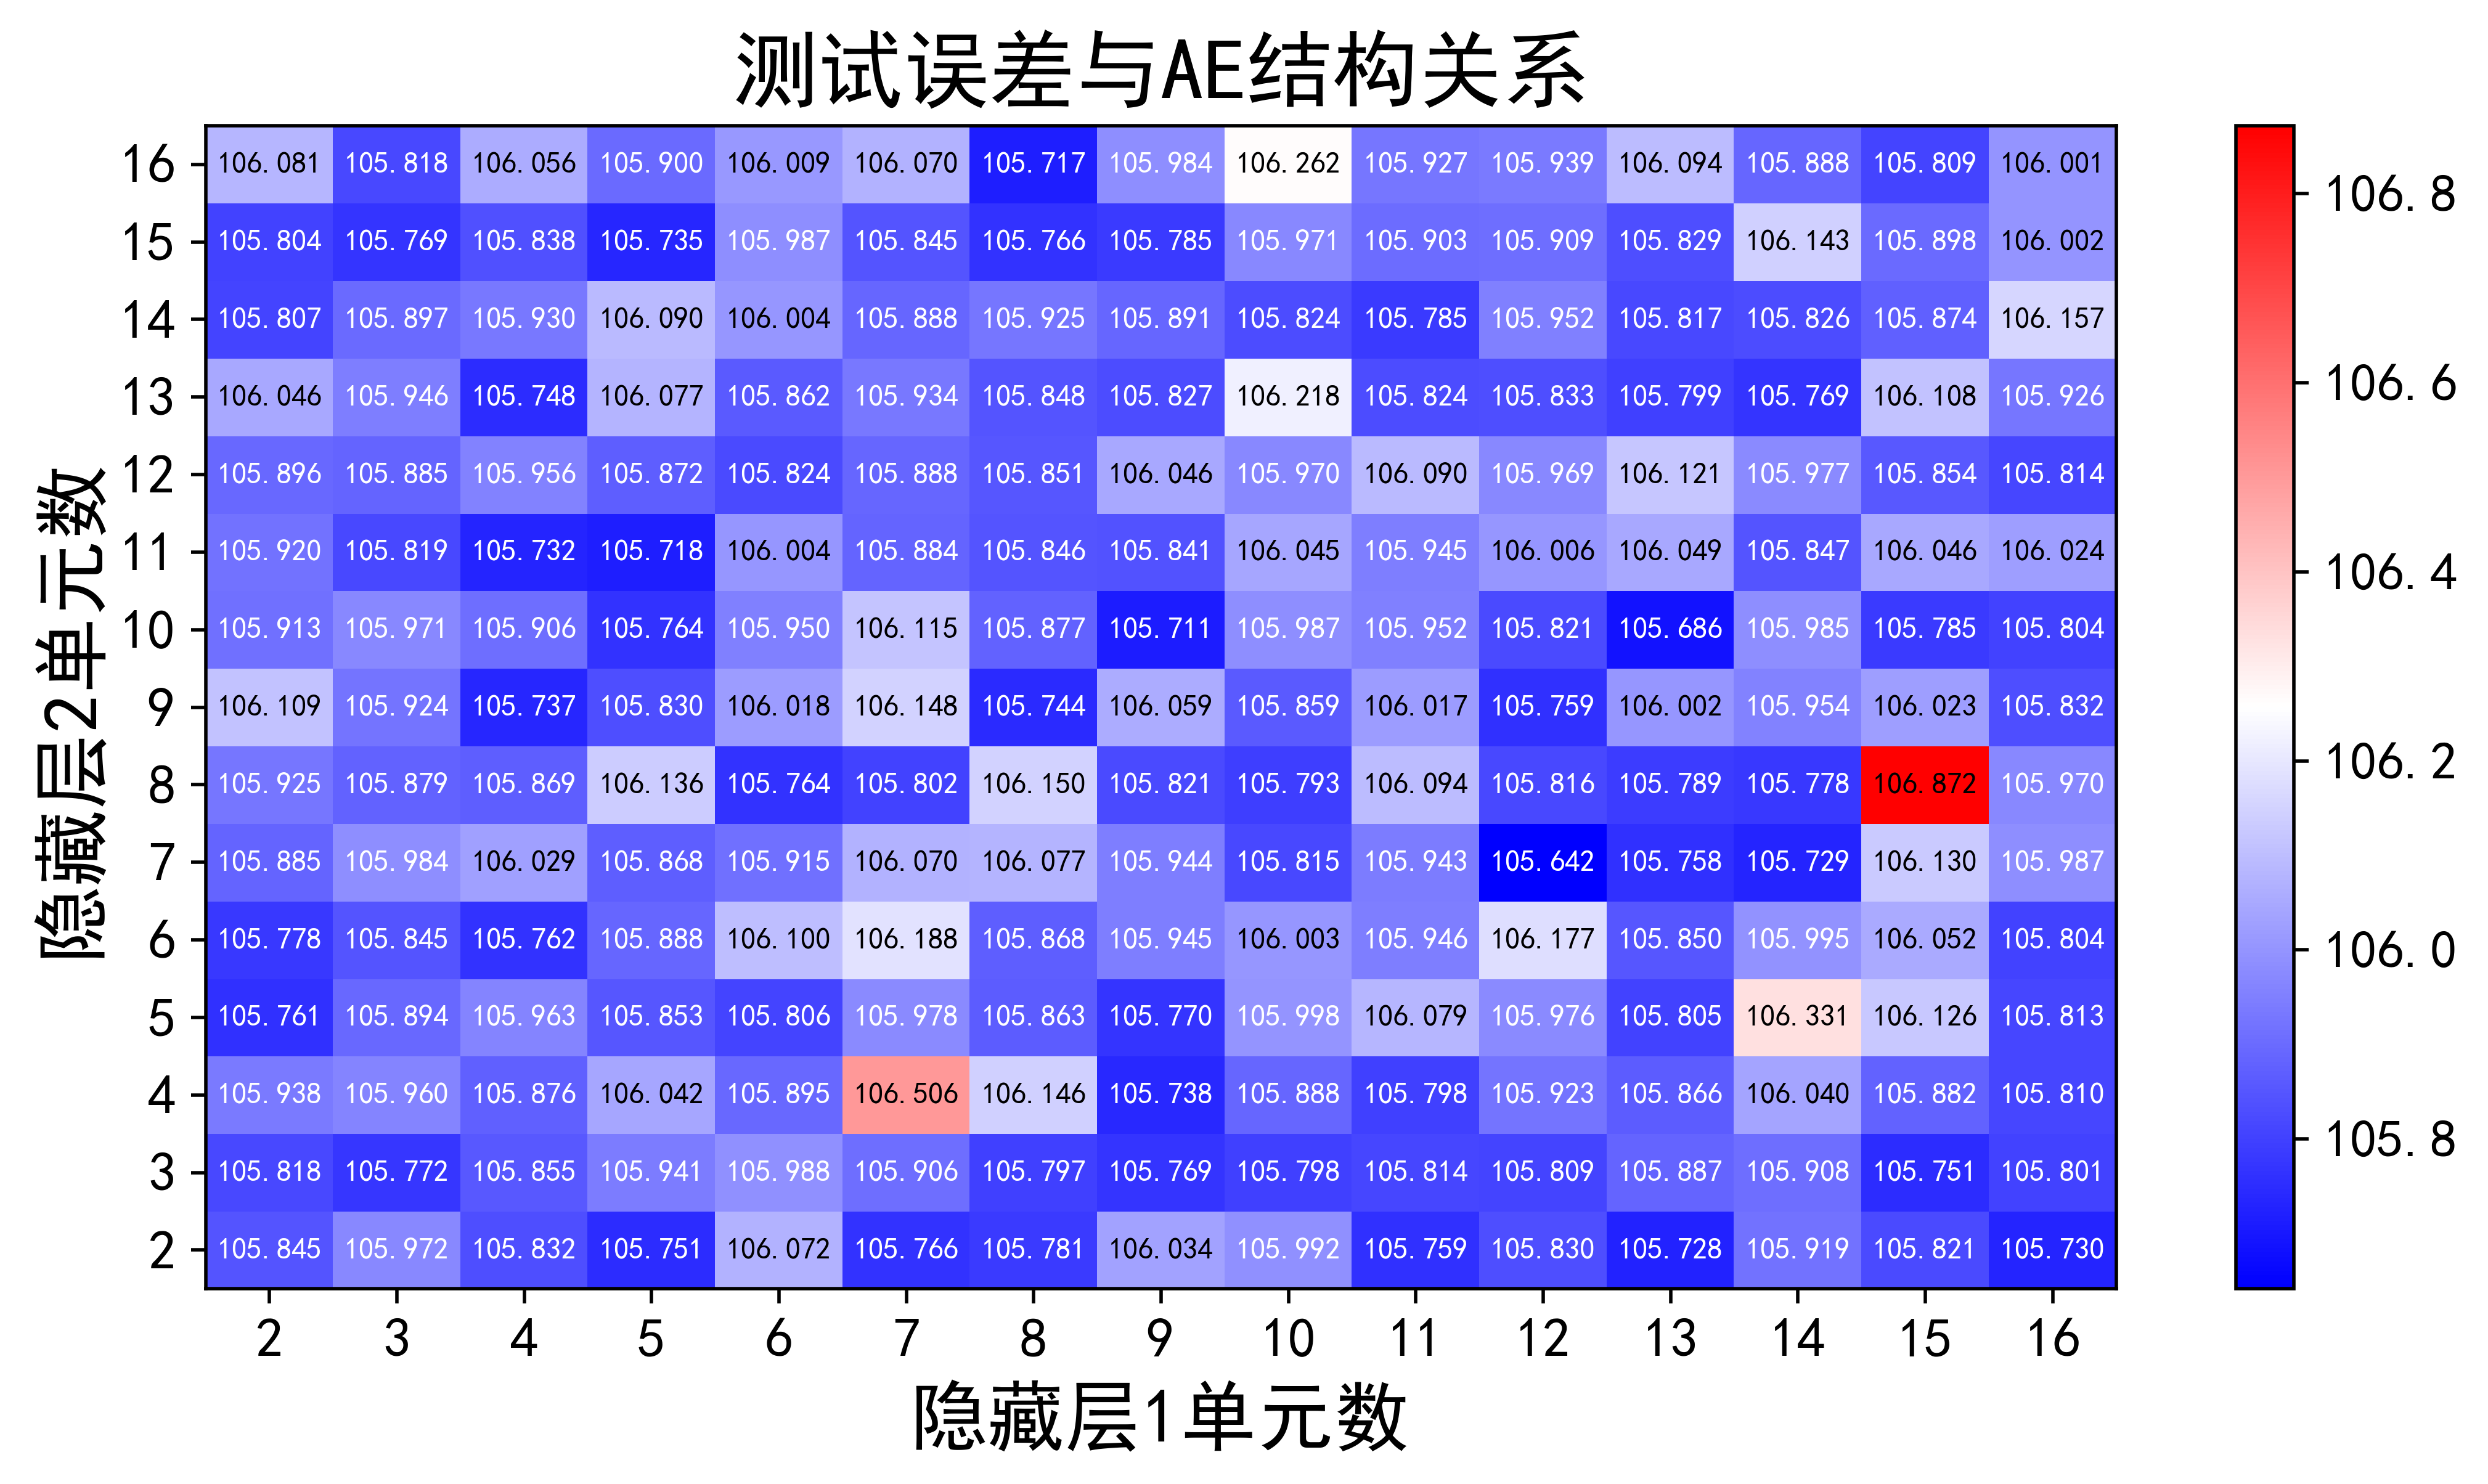

In [3]:
from Visualization import *
LossStruct = pd.read_csv("Networks/AE_Comparison.csv").to_numpy()

TestLossHeatMap(
    DATA=LossStruct, TITLE="测试误差与AE结构关系", LABELS=["隐藏层1单元数", "隐藏层2单元数"], SAVE_FIG=True
)

## 2. 训练自编码器


根据对比结果，选择网络结构


In [4]:
# 选取需要的列
COLUMN_INDEX_AE = ["LAYER_1", "LAYER_2"]
layer_1, layer_2 = pd.read_csv("Networks/AE_Comparison.csv").loc[0, COLUMN_INDEX_AE]
layer_1 = int(layer_1)
layer_2 = int(layer_2)

# # 以上仅作展示用
# layer_1 = 6
# layer_2 = 3
print("第1层隐藏层单元数", layer_1, "\n第2层隐藏层单元数", layer_2)

第1层隐藏层单元数 12 
第2层隐藏层单元数 7


训练网络


In [5]:
MyAE = MyAutoencoder(
    input_size=5, hidden_size_1=layer_1, hidden_size_2=layer_2, dropout_prob=0.25
)
INIT_WEIGHTS_XAVIER(MyAE)
optimizer = torch.optim.Adam(MyAE.parameters(), lr=0.005, weight_decay=1e-5)
LOSS_HISTORY_TRAIN, LOSS_HISTORY_TEST = TRAIN_WITH_PROGRESS_BAR(
    MyAE,
    NUM_EPOCHS=150,
    OPTIMIZER=optimizer,
    TRAIN_LOADER=train_loader,
    TEST_LOADER=test_loader,
    LOSS_TYPE=nn.MSELoss(),
    DEVICE=0,
    GRAD_MAX=2,
)

PyTorch Version: 1.11.0
Training on cuda:0
====================================Start training====================================


Epoch 150/150: 100%|██████████| 384/384 [00:02<00:00, 156.85batch/s, loss=32.3]


====================================Finish training====================================



可视化


c:\Users\CTC\Desktop\temporary working library\Python\Optimization_Group_Work\Visualization.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


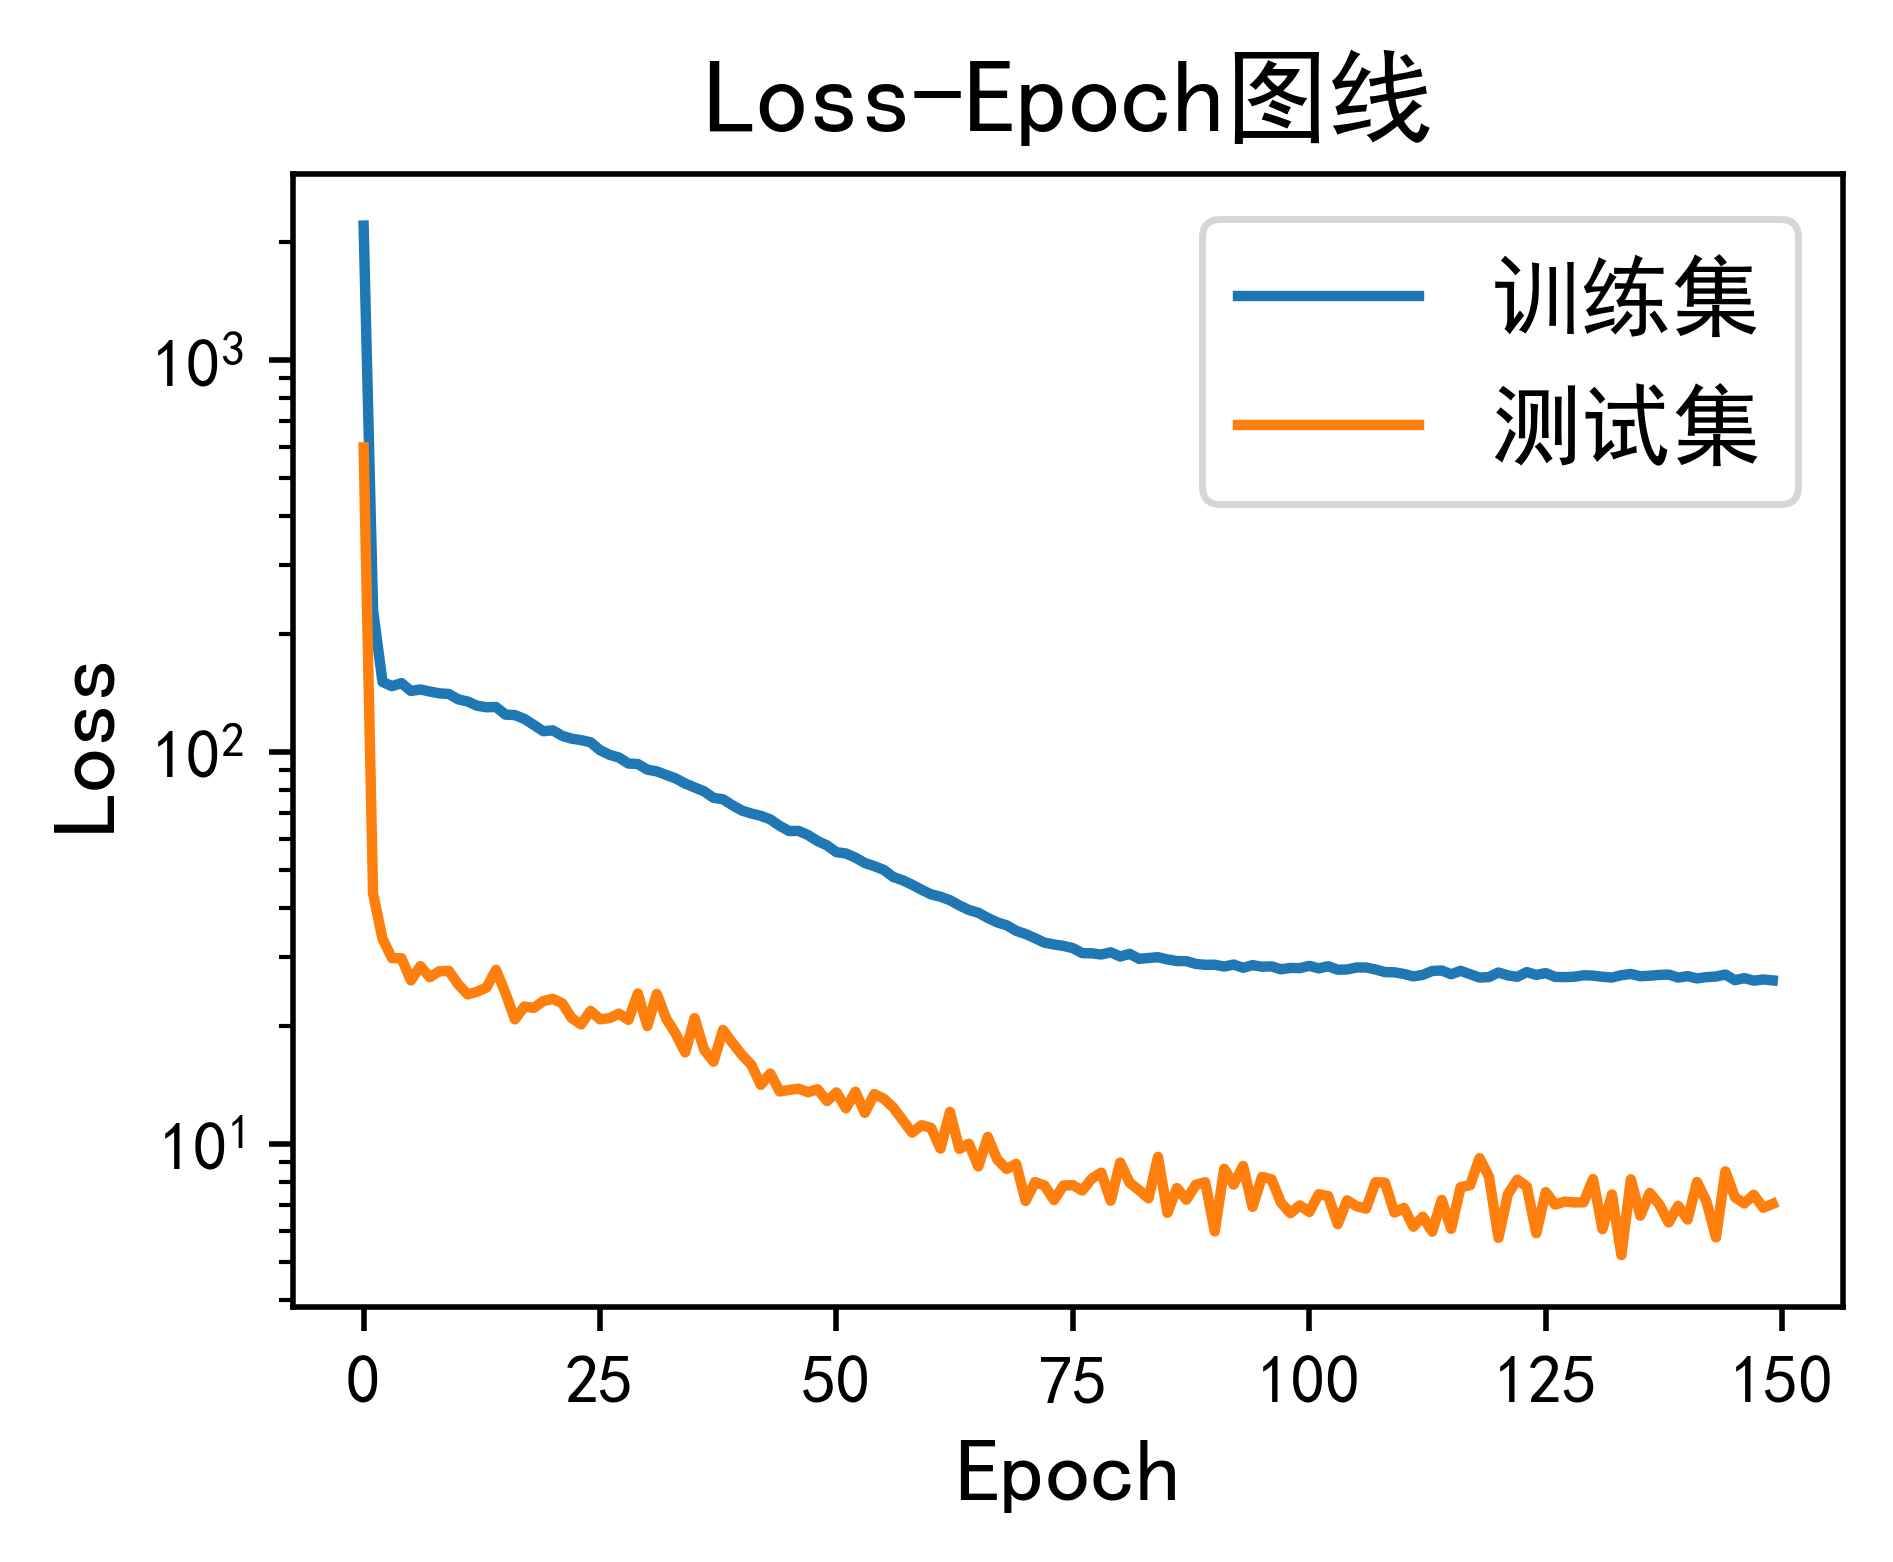

In [6]:
LossEpochPlot(
    LOSS_HISTORY=(LOSS_HISTORY_TRAIN, LOSS_HISTORY_TEST),
    LEGEND=["训练集", "测试集"],
    TITLE="Loss-Epoch图线",
    SAVE_FIG=True,
)

## 3. 保存网络


In [7]:
torch.save(MyAE.encoder.state_dict(), "Networks/Encoder.pth")
torch.save(MyAE.decoder.state_dict(), "Networks/Decoder.pth")

调用保存的网络示例


In [8]:
net_temp = MyAutoencoder(5, layer_1, layer_2, dropout_prob=0).encoder
net_temp.load_state_dict(torch.load("Networks/Encoder.pth"))

net_temp.eval()
with torch.no_grad():
    print(net_temp(torch.randn(1, 5)))

tensor([[ 0.1169,  2.8705,  0.1107, -2.5034,  2.4937, -2.9752,  3.0708]])
